<a href="https://colab.research.google.com/github/jmbmartins/Human-Recognition-in-Surveillance-Settings/blob/main/pix2pix_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo Pix2Pix Implementado e Treinado do Zero

Users Ids detected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 64, 65, 66, 67, 68, 69]
train users: [45, 14, 18, 13, 36, 33, 19, 68, 43, 40, 39, 9, 17, 8, 25, 23, 24, 35, 3, 42, 30, 4, 67, 65, 21, 69, 11, 5, 38, 6, 1, 10, 29, 16, 44, 64, 31, 7, 66, 12]
val users: [2, 27, 37, 32, 22]
test users: [41, 28, 34, 20, 26, 15]
738/738 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.1327 - mean_absolute_percentage_error: 7208888.0000 
Epoch 1: saving model to /content/drive/MyDrive/Computer Vision/Projeto/pix2pix_model_checkpoint_1_seg.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


738/738 [==============================] - 28062s 38s/step - loss: 0.0375 - mean_absolute_error: 0.1327 - mean_absolute_percentage_error: 7208888.0000 - val_loss: 0.0601 - val_mean_absolute_error: 0.1777 - val_mean_absolute_percentage_error: 7284660.5000


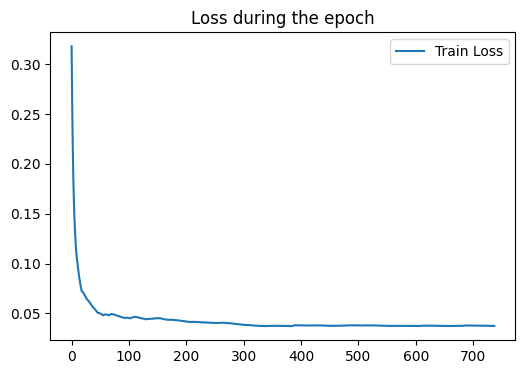

111/111 [==============================] - 1677s 15s/step - loss: 0.0456 - mean_absolute_error: 0.1457 - mean_absolute_percentage_error: 5648949.0000
Test loss: 0.04559669271111488
Test MAE: 0.14571882784366608
Test MAPE: 5648949.0
Validation loss: 0.060095492750406265
Validation MAE: 0.1777077317237854


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint


# Constants
BATCH_SIZE = 32
base_dir = '/content/drive/MyDrive/Computer Vision/Projeto/segmented_images'

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []
        self.batch_val_losses = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])

    def on_epoch_end(self, epoch, logs=None):
        self.batch_val_losses.append(logs['val_loss'])



# Define the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def create_model():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  down_stack = [
      downsample(64, 4, apply_batchnorm=False),
      downsample(128, 4),
      downsample(256, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4),
      upsample(512, 4),
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  x = inputs

  skips = []
  for down in down_stack:
      x = down(x)
      skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


# Get a list of all unique user IDs
user_ids = sorted(set(int(dir.split('_')[0]) for dir in os.listdir(base_dir)))

print("Users Ids detected:", user_ids)

# Shuffle the user IDs
np.random.shuffle(user_ids)

# Split the user IDs into training, validation, and test sets
num_train = int(0.8 * len(user_ids))
num_val = int(0.1 * len(user_ids))
train_users = user_ids[:num_train]
print("train users:", train_users)
val_users = user_ids[num_train:num_train + num_val]
print("val users:", val_users)
test_users = user_ids[num_train + num_val:]
print("test users:", test_users)

# Define a function to load and preprocess the images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    return image

# Define a function to load a dataset
def load_dataset(user_ids):
    # Initialize the datasets
    input_images = tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))
    ground_truth_images = tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))
    for user_id in user_ids:
      for video_index in range(1, 3):
          # Define the input and ground truth directories
          input_dir = os.path.join(base_dir, f'{user_id:03}_U_{video_index}')
          ground_truth_dir = os.path.join(base_dir, f'{user_id:03}_E_{video_index}')

          # Load the input and ground truth images
          input_images = input_images.concatenate(tf.data.Dataset.list_files(input_dir+'/*.jpg'))
          ground_truth_images = ground_truth_images.concatenate(tf.data.Dataset.list_files(ground_truth_dir+'/*.jpg'))

    # Apply the function to the input and ground truth images
    input_images = input_images.map(load_image)
    ground_truth_images = ground_truth_images.map(load_image)

    # Zip the input and ground truth datasets together
    dataset = tf.data.Dataset.zip((input_images, ground_truth_images))

    return dataset

# Load the training, validation, and test datasets
train_dataset = load_dataset(train_users)
val_dataset = load_dataset(val_users)
test_dataset = load_dataset(test_users)

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Define the Pix2Pix model
model = create_model()

# Define the optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

# Define the checkpoint callback
checkpoint_path = "/content/drive/MyDrive/Computer Vision/Projeto/pix2pix_model_checkpoint_{epoch}_seg.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq='epoch',  # Save after every epoch
    verbose=1
)


# Create a new instance of the custom callback
callback = CustomCallback()

# Train the model
history = model.fit(train_dataset, epochs=1, validation_data=val_dataset, callbacks=[callback, checkpoint_callback])

# Plot the loss during the epoch
plt.figure(figsize=(6, 4))
plt.plot(callback.batch_losses, label='Train Loss')
plt.legend()
plt.title('Loss during the epoch')
plt.show()

# Evaluate the model on the test set
test_loss, test_mae, test_mape = model.evaluate(test_dataset)

print(f'Test loss: {test_loss}')
print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape}')

# Print the final loss and metrics on the validation set
val_loss = history.history['val_loss'][-1]
val_mae = history.history['val_mean_absolute_error'][-1]

print(f'Validation loss: {val_loss}')
print(f'Validation MAE: {val_mae}')


# Save the model
model.save('/content/drive/MyDrive/Computer Vision/Projeto/pix2pix_model.h5')

Modelo Pix2Pix Pré-Treinado

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout
import numpy as np
import matplotlib.pyplot as plt

# Constants
BATCH_SIZE = 32
base_dir = '/content/drive/MyDrive/Computer Vision/Projeto/heads_square'

class Encoder(Layer):
    def __init__(self, filters, apply_bn=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.filters = filters
        self.apply_bn = apply_bn

        self.c = Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)
        self.bn = BatchNormalization()
        self.act = LeakyReLU()

    def call(self, X):
        X = self.c(X)
        if self.apply_bn:
            X = self.bn(X)
        X = self.act(X)
        return X

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "apply_bn":self.apply_bn
        }

class Decoder(Layer):
    def __init__(self, filters, apply_drop=True, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.filters = filters
        self.apply_drop = apply_drop

        self.c = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)
        self.bn = BatchNormalization()
        self.drop = Dropout(0.5)
        self.act = LeakyReLU()

    def call(self, X):
        X = self.c(X)
        X = self.bn(X)
        if self.apply_drop:
            X = self.drop(X)
        X = self.act(X)
        return X

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "apply_drop": self.apply_drop
        }

# Define the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Get a list of all unique user IDs
user_ids = sorted(set(int(dir.split('_')[0]) for dir in os.listdir(base_dir)))

# Shuffle the user IDs
np.random.shuffle(user_ids)

# Split the user IDs into training, validation, and test sets
num_train = int(0.8 * len(user_ids))
num_val = int(0.1 * len(user_ids))
train_users = user_ids[:num_train]
val_users = user_ids[num_train:num_train + num_val]
test_users = user_ids[num_train + num_val:]

# Define a function to load and preprocess the images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    return image

# Define a function to load a dataset
def load_dataset(user_ids):
    # Initialize the datasets
    input_images = tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))
    ground_truth_images = tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))
    for user_id in user_ids:
      for video_index in range(1, 3):
          # Define the input and ground truth directories
          input_dir = os.path.join(base_dir, f'{user_id:03}_U_{video_index}')
          ground_truth_dir = os.path.join(base_dir, f'{user_id:03}_E_{video_index}')

          # Load the input and ground truth images
          input_images = input_images.concatenate(tf.data.Dataset.list_files(input_dir+'/*.jpg'))
          ground_truth_images = ground_truth_images.concatenate(tf.data.Dataset.list_files(ground_truth_dir+'/*.jpg'))

    # Apply the function to the input and ground truth images
    input_images = input_images.map(load_image)
    ground_truth_images = ground_truth_images.map(load_image)

    # Zip the input and ground truth datasets together
    dataset = tf.data.Dataset.zip((input_images, ground_truth_images))

    return dataset

# Load the training, validation, and test datasets
train_dataset = load_dataset(train_users)
val_dataset = load_dataset(val_users)
test_dataset = load_dataset(test_users)

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Computer Vision/Projeto/Caleb-Face-Generator.h5',
    custom_objects={'Encoder': Encoder, 'Decoder': Decoder}
)

# Define the optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

# Define the checkpoint callback
checkpoint_path = "/content/drive/MyDrive/Computer Vision/Projeto/pix2pix_model_checkpoint_{epoch}_{batch}.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_freq=150*BATCH_SIZE, verbose=1)

# Fine-tune the model
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[early_stopping, checkpoint_callback])

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_mae, test_mape = model.evaluate(test_dataset)

print(f'Test loss: {test_loss}')
print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape}')

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True)

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# Save the fine-tuned model
model.save('/content/drive/MyDrive/Computer Vision/Projeto/pix2pix-fine.h5')

Epoch 1/5
  16/1056 [..............................] - ETA: 14:46:19 - loss: 0.0561 - mean_absolute_error: 0.1920 - mean_absolute_percentage_error: 57542276.0000

Teste Visual ao Modelo Pré-Treinado

1/1 [==============================] - 1s 997ms/step


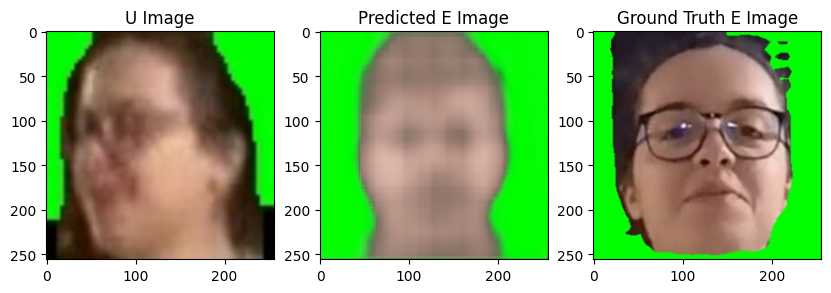

In [2]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the trained model
model = load_model('/content/drive/MyDrive/Computer Vision/Projeto/pix2pix_model_checkpoint_1_seg.h5')

# Define a function to load and preprocess the images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    return image

# Load the 'U' image
u_image_path = '/content/drive/MyDrive/Computer Vision/Projeto/segmented_images/028_U_2/023s.jpg'
u_image = load_image(u_image_path)

# Add an extra dimension because the model expects batches
u_image = tf.expand_dims(u_image, axis=0)

# Use the model to predict the 'E' image
e_image_pred = model.predict(u_image)

# Remove the extra dimension
e_image_pred = tf.squeeze(e_image_pred, axis=0)

# Load the ground truth 'E' image
e_image_path = '/content/drive/MyDrive/Computer Vision/Projeto/segmented_images/028_E_2/023s.jpg'  # replace with your actual file path
e_image_gt = load_image(e_image_path)

# Display the 'U' image, the predicted 'E' image, and the ground truth 'E' image
plt.figure(figsize=(10, 3))  # Adjusted size

plt.subplot(1, 3, 1)
plt.imshow(u_image[0])
plt.title('U Image')

plt.subplot(1, 3, 2)
plt.imshow(e_image_pred)
plt.title('Predicted E Image')

plt.subplot(1, 3, 3)
plt.imshow(e_image_gt)
plt.title('Ground Truth E Image')

plt.show()